## Import necessary packages tutorial

In [1]:
import gym
import renom as rm
from renom.utility.initializer import Uniform, GlorotUniform
from renom_rl.ddpg import DDPG

## Deifne the environment tutorial

In [2]:
env = gym.make('Pendulum-v0')
print(env.action_space.shape)
print(env.observation_space.shape)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
(1,)
(3,)


## Define the actor network tutorial

In [3]:
class Actor(rm.Model):
    
    '''Here considered 3-layer network (excluding input layer). Feel free to change the network depth 
    and check the results. The output-layer number of nuerons are equal to number of actions.
    In the example of OpenAI Gym's Pendlum-v0 environment number of actions are 1.'''
    
    def __init__(self, env, layer_size):
        self._layers = []
        self.env = env
        self.action_size = self.env.action_space.shape[0] if hasattr(self.env, "action_space") else env.action_size
        self.high = self.env.action_space.high[0] if hasattr(self.env, "action_space") else env.high
        self._l1 = rm.Dense(400, initializer=GlorotUniform())
        self._l2 = rm.Dense(300, initializer=GlorotUniform())
        self._l3 = rm.Dense(self.action_size, initializer=Uniform(min=-0.003, max=0.003))
    
    def forward(self, x):
        '''Neural Network inputs are state information, outputs are actions. '''
        h1 = rm.relu(self._l1(x))
        h2 = rm.relu(self._l2(h1))
        h3 = rm.tanh(self._l3(h2)) 
        h = h3*self.high
        return h
    
    def weigiht_decay(self):
        '''To minimize over fitting considered L2-norm (it is an optional)'''
        weight_decay = 0
        for i in range(len(self._layers)):
            weight_decay += rm.sum(self._layers[i].params.w**2)
        return weight_decay


# Define the Critic network tutorial

In [4]:
class Critic(rm.Model):
    '''Here considered a 3-layer network (input layer, hidden layer-1, hidden layer-2, output layer)
        At input-layer state information, 2nd-hidden layer actions are applied, last layer has a single neuron'''
    def __init__(self, env, layer_size):        
        self._layers = []
        self.env = env
        self._l1 = rm.Dense(layer_size[0], initializer=GlorotUniform())
        self._l2 = rm.Dense(layer_size[1], initializer=GlorotUniform())
        self._l3 = rm.Dense(1, initializer=Uniform(min=-0.003, max=0.003))
  
    def forward(self, x, action):
        '''Q(s,a) calculation for a given (state, action) pair'''
        h1 = rm.relu(self._l1(x))
        h2 = rm.relu(self._l2(rm.concat(h1, action))) # actions are applied at 2nd hidden layer
        h = self._l3(h2)        
        return h
    
    def weigiht_decay(self):
        '''To minimize over fitting considered L2-norm (it is an optional)'''
        weight_decay = 0
        for i in range(len(self._layers)):
            weight_decay += rm.sum(self._layers[i].params.w**2)
        return weight_decay

## Instantiating the actor & ciritic networks 

In [5]:
layer_size = [400, 300] # two-hidden layers dimension
actor_network = Actor(env=env,layer_size=layer_size)
critic_network = Critic(env=env, layer_size=layer_size)

## Instantiating the DDPG class

In [6]:
ddpg = DDPG(env, actor_network, critic_network, loss_func=lambda x, y:rm.mse(x, y) + 0.0001*critic_network.weigiht_decay())
# ddpg = DDPG(env=env) # for default

## Training 

In [7]:
ddpg.train(episode=400, episode_step=200, exploration_step=30000, min_exploration_rate=0.0001)

episode 001 avg_loss: 2.870 total_reward [train:-1608.949 test:-] exploration:0.993: 100%|██████████| 200/200 [00:05<00:00, 37.40it/s]
episode 002 avg_loss: 0.123 total_reward [train:-1203.914 test:-] exploration:0.987: 100%|██████████| 200/200 [00:05<00:00, 38.65it/s]
episode 003 avg_loss: 0.027 total_reward [train:-1638.847 test:-] exploration:0.980: 100%|██████████| 200/200 [00:05<00:00, 34.86it/s]
episode 004 avg_loss: 0.016 total_reward [train:-1491.019 test:-] exploration:0.973: 100%|██████████| 200/200 [00:06<00:00, 32.53it/s]
episode 005 avg_loss: 0.013 total_reward [train:-1567.252 test:-] exploration:0.967: 100%|██████████| 200/200 [00:06<00:00, 26.91it/s]
episode 006 avg_loss: 0.015 total_reward [train:-1188.995 test:-] exploration:0.960: 100%|██████████| 200/200 [00:05<00:00, 34.69it/s]
episode 007 avg_loss: 0.019 total_reward [train:-1569.526 test:-] exploration:0.953: 100%|██████████| 200/200 [00:06<00:00, 29.06it/s]
episode 008 avg_loss: 0.024 total_reward [train:-1156.9

episode 061 avg_loss: 0.007 total_reward [train:-1454.938 test:-] exploration:0.593: 100%|██████████| 200/200 [00:06<00:00, 31.48it/s]
episode 062 avg_loss: 0.024 total_reward [train:-1416.395 test:-] exploration:0.587: 100%|██████████| 200/200 [00:06<00:00, 29.40it/s]
episode 063 avg_loss: 0.011 total_reward [train:-1538.415 test:-] exploration:0.580: 100%|██████████| 200/200 [00:06<00:00, 31.00it/s]
episode 064 avg_loss: 0.018 total_reward [train:-1343.822 test:-] exploration:0.573: 100%|██████████| 200/200 [00:06<00:00, 27.15it/s]
episode 065 avg_loss: 0.008 total_reward [train:-1394.924 test:-] exploration:0.567: 100%|██████████| 200/200 [00:06<00:00, 29.58it/s]
episode 066 avg_loss: 0.014 total_reward [train:-1279.133 test:-] exploration:0.560: 100%|██████████| 200/200 [00:06<00:00, 27.03it/s]
episode 067 avg_loss: 0.014 total_reward [train:-1298.689 test:-] exploration:0.553: 100%|██████████| 200/200 [00:06<00:00, 32.59it/s]
episode 068 avg_loss: 0.013 total_reward [train:-1311.3

episode 121 avg_loss: 0.006 total_reward [train:-1174.126 test:-] exploration:0.193: 100%|██████████| 200/200 [00:07<00:00, 28.43it/s]
episode 122 avg_loss: 0.009 total_reward [train:-1185.604 test:-] exploration:0.187: 100%|██████████| 200/200 [00:07<00:00, 27.26it/s]
episode 123 avg_loss: 0.013 total_reward [train:-1201.778 test:-] exploration:0.180: 100%|██████████| 200/200 [00:07<00:00, 32.61it/s]
episode 124 avg_loss: 0.007 total_reward [train:-1178.804 test:-] exploration:0.173: 100%|██████████| 200/200 [00:06<00:00, 29.82it/s]
episode 125 avg_loss: 0.005 total_reward [train:-1196.088 test:-] exploration:0.167: 100%|██████████| 200/200 [00:05<00:00, 34.90it/s]
episode 126 avg_loss: 0.013 total_reward [train:-1190.439 test:-] exploration:0.160: 100%|██████████| 200/200 [00:05<00:00, 31.92it/s]
episode 127 avg_loss: 0.008 total_reward [train:-1260.394 test:-] exploration:0.153: 100%|██████████| 200/200 [00:06<00:00, 30.19it/s]
episode 128 avg_loss: 0.021 total_reward [train:-1232.0

episode 181 avg_loss: 0.005 total_reward [train:-1492.153 test:-] exploration:0.000: 100%|██████████| 200/200 [00:06<00:00, 30.03it/s]
episode 182 avg_loss: 0.007 total_reward [train:-1368.990 test:-] exploration:0.000: 100%|██████████| 200/200 [00:06<00:00, 31.27it/s]
episode 183 avg_loss: 0.003 total_reward [train:-1460.056 test:-] exploration:0.000: 100%|██████████| 200/200 [00:05<00:00, 36.46it/s]
episode 184 avg_loss: 0.004 total_reward [train:-1480.188 test:-] exploration:0.000: 100%|██████████| 200/200 [00:06<00:00, 32.73it/s]
episode 185 avg_loss: 0.004 total_reward [train:-1511.465 test:-] exploration:0.000: 100%|██████████| 200/200 [00:05<00:00, 37.67it/s]
episode 186 avg_loss: 0.005 total_reward [train:-1512.420 test:-] exploration:0.000: 100%|██████████| 200/200 [00:05<00:00, 33.50it/s]
episode 187 avg_loss: 0.005 total_reward [train:-1514.321 test:-] exploration:0.000: 100%|██████████| 200/200 [00:07<00:00, 27.82it/s]
episode 188 avg_loss: 0.006 total_reward [train:-1508.4

episode 241 avg_loss: 0.004 total_reward [train:-1159.948 test:-] exploration:0.000: 100%|██████████| 200/200 [00:06<00:00, 28.89it/s]
episode 242 avg_loss: 0.005 total_reward [train:-1151.848 test:-] exploration:0.000: 100%|██████████| 200/200 [00:06<00:00, 33.26it/s]
episode 243 avg_loss: 0.004 total_reward [train:-1350.090 test:-] exploration:0.000: 100%|██████████| 200/200 [00:05<00:00, 34.78it/s]
episode 244 avg_loss: 0.006 total_reward [train:-1516.012 test:-] exploration:0.000: 100%|██████████| 200/200 [00:07<00:00, 27.40it/s]
episode 245 avg_loss: 0.003 total_reward [train:-1163.722 test:-] exploration:0.000: 100%|██████████| 200/200 [00:05<00:00, 36.57it/s]
episode 246 avg_loss: 0.006 total_reward [train:-1160.268 test:-] exploration:0.000: 100%|██████████| 200/200 [00:05<00:00, 34.44it/s]
episode 247 avg_loss: 0.011 total_reward [train:-1109.434 test:-] exploration:0.000: 100%|██████████| 200/200 [00:07<00:00, 28.38it/s]
episode 248 avg_loss: 0.004 total_reward [train:-1168.2

episode 301 avg_loss: 0.006 total_reward [train:-1490.427 test:-] exploration:0.000: 100%|██████████| 200/200 [00:06<00:00, 32.22it/s]
episode 302 avg_loss: 0.005 total_reward [train:-1332.990 test:-] exploration:0.000: 100%|██████████| 200/200 [00:05<00:00, 38.02it/s]
episode 303 avg_loss: 0.003 total_reward [train:-1372.679 test:-] exploration:0.000: 100%|██████████| 200/200 [00:05<00:00, 38.33it/s]
episode 304 avg_loss: 0.004 total_reward [train:-1350.619 test:-] exploration:0.000: 100%|██████████| 200/200 [00:05<00:00, 35.17it/s]
episode 305 avg_loss: 0.004 total_reward [train:-1382.855 test:-] exploration:0.000: 100%|██████████| 200/200 [00:05<00:00, 41.62it/s]
episode 306 avg_loss: 0.005 total_reward [train:-1362.375 test:-] exploration:0.000: 100%|██████████| 200/200 [00:06<00:00, 30.20it/s]
episode 307 avg_loss: 0.006 total_reward [train:-1359.125 test:-] exploration:0.000: 100%|██████████| 200/200 [00:06<00:00, 29.79it/s]
episode 308 avg_loss: 0.006 total_reward [train:-1497.7

episode 361 avg_loss: 0.005 total_reward [train:-1689.263 test:-] exploration:0.000: 100%|██████████| 200/200 [00:04<00:00, 45.86it/s]
episode 362 avg_loss: 0.007 total_reward [train:-1820.848 test:-] exploration:0.000: 100%|██████████| 200/200 [00:04<00:00, 41.05it/s]
episode 363 avg_loss: 0.005 total_reward [train:-1882.832 test:-] exploration:0.000: 100%|██████████| 200/200 [00:06<00:00, 31.90it/s]
episode 364 avg_loss: 0.003 total_reward [train:-1399.143 test:-] exploration:0.000: 100%|██████████| 200/200 [00:05<00:00, 35.88it/s]
episode 365 avg_loss: 0.005 total_reward [train:-1289.636 test:-] exploration:0.000: 100%|██████████| 200/200 [00:06<00:00, 27.03it/s]
episode 366 avg_loss: 0.004 total_reward [train:-1503.275 test:-] exploration:0.000: 100%|██████████| 200/200 [00:06<00:00, 32.33it/s]
episode 367 avg_loss: 0.006 total_reward [train:-1518.743 test:-] exploration:0.000: 100%|██████████| 200/200 [00:06<00:00, 31.31it/s]
episode 368 avg_loss: 0.003 total_reward [train:-1470.0

## Testing

In [8]:
test_reward_list = ddpg.test()
print(test_reward_list)

-1188.92223572


## Plotting the test result

Text(0,0.5,'Total Rewards per Episode')

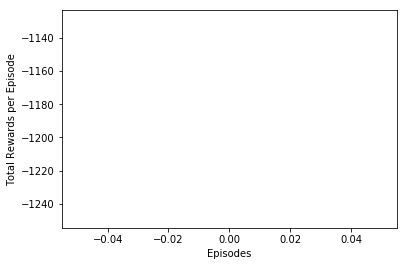

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(test_reward_list)
plt.xlabel("Episodes")
plt.ylabel("Total Rewards per Episode")